In [ ]:
import json

def load_file(file_path):
    """

    :param file_path: path to the json file
    :return: an array in which each entry is tuple [text, classification label]
    """
    with open(file_path) as json_file:
        raw_data = json.load(json_file)
        return convert_data(raw_data)


def convert_data(raw_data):
    data = []
    for elem in raw_data:
        data.append([elem["reviewerID"], elem["asin"], elem["helpful"], elem["reviewText"], elem["overall"], elem["summary"], elem["unixReviewTime"], elem["reviewTime"]])
    return data

In [ ]:
import pandas as pd
data = load_file("ElectronicsReviews1.json")

df = pd.DataFrame(data, columns = ['reviewerID', 'asin', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime'])
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2NYK9KWFMJV4Y,B00KIMX4EY,"[0, 0]",I received my transmitted as a review sample f...,5.0,Easy installation and superb performance,1402012800,"06 6, 2014"
1,A1LAGBKLFBEVXL,B00KIMX4EY,"[1, 1]","I have a 3.5mm auxillary jack in my car, but i...",5.0,Excellent device with good audio quality,1402358400,"06 10, 2014"
2,A240FRPD4MEXND,B00KIMX4EY,"[0, 0]",I do not pretend to understand just how this a...,5.0,An Amazing Transmitter,1406073600,"07 23, 2014"
3,A1ZRHBODI7I015,B00KIMX4EY,"[0, 0]",Great product that saved me hundreds of dollar...,5.0,A Wallet-Saver,1405123200,"07 12, 2014"
4,A8NIGRJORA9KT,B00KIMX4EY,"[1, 2]",Went on a Road Trip back east.Drove back used ...,1.0,Broke one week after i recived it,1403136000,"06 19, 2014"


In [ ]:
import spacy
import nltk

nlp = spacy.load('en', disable=['parser', 'ner'])
df.loc[3]['reviewText']


"Great product that saved me hundreds of dollars.  My wife is driving cross country in a car and didn't want to carry hundreds of CDs so she wanted me to replace the radio with a bluetooth-enabled radio.  Um... no.  Saw this, bought it, use it and it works extremely well.  Good sound, no static.  Even the phone hook up works.  If there's any problems on the cross-country trek, I'll update this, but right now it's working exceptionally well."

In [ ]:
import random

#This peice of code just takes in a random index and displays the review text
index = random.randint(0, df.shape[0])
text = df.iloc[index]['reviewText']
print(text)

This Belkin NetCam HD+ camera is an extremely basic camera video quality that is barely 720p - definitely not &#34;HD+&#34;. The basics are all there - IR filter, IR lights, audio and WeMo compatibility. Sadly, the camera itself just isn't that good. When there are comparable products like the many Foscam cameras with active PTZ, 2 Dropcam versions and a variety of Logitech Alert products, there just isn't much room in the market for a mediocre camera like this. The apps are severely lacking, and it requires a &#34;cloud&#34; account just to use, which means it is impossible to setup somewhere without Internet (like a cabin) and use as a local only monitoring camera. Audio is useless, so if you planned to use this at your porch to talk to the mailman, forget it.


In [ ]:
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

#read the stopwords from the provided set of files
from sklearn.feature_extraction.text import TfidfVectorizer
with open('StopWords_GenericLong.txt', 'r') as f:
 x_gl = f.readlines()
with open('StopWords_Names.txt', 'r') as f:
 x_n = f.readlines()
with open('StopWords_DatesandNumbers.txt', 'r') as f:
 x_d = f.readlines()

#import nltk stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

#combine all stopwords
[stopwords.append(x.rstrip()) for x in x_gl]
[stopwords.append(x.rstrip()) for x in x_n]
[stopwords.append(x.rstrip()) for x in x_d]

#change all stopwords into lowercase
stopwords_lower = [s.lower() for s in stopwords]

#Get the length of total number of entries in the list
nrows = len(df)
preprocessed_list = []
preprocessed_column = []

for row in range(0, nrows):
  #lemmatize and transform word into its original form
  words = [token.lemma_ for token in nlp(df.iloc[row]['reviewText']) if not token.is_punct]
  #print("Words length : ",len(words))
  #tokenization and remove punctuations
  #words = [str(token) for token in nlp(text) if not token.is_punct] 
  #remove digits and other symbols except "@"--used to remove email
  words = [re.sub(r"[^A-Za-z@]", "", word) for word in words]
  #remove websites and email address
  words = [re.sub(r"\S+com", "", word) for word in words]
  words = [re.sub(r"\S+@\S+", "", word) for word in words]
  #remove empty spaces 
  words = [word for word in words if word!=' ']
  words = [word.lower() for word in words if word.lower() not in stopwords_lower]
  words = [word for word in words if word!='pron']
  preprocessed_item = []
  #combine a list into one string   
  preprocessed = " ".join(words)
  #Create a list of preprocessed words
  preprocessed_item.append(preprocessed)
  #df['preprocessed'] = preprocessed
  preprocessed_column.append(preprocessed)

#Besides the word counts in each document, TFIDF also includes the occurrence of this word in other documents.
#The higher term frequency indicating a higher TFIDF value, presenting the fact that the word wj plays a very important role in document i by appearing significant times.
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
vectorizer.fit(preprocessed_item)
vector = vectorizer.transform(preprocessed_item)
#summarize encoded vector
#you can uncomment the print statements to display the various values
#print("List of unique words:", vectorizer.vocabulary_)
#print("Shape of the sparse matrix:",vector.shape)
#print(vector.toarray())
preprocessed_list.append(vector.toarray())

df['preprocessed_column'] = preprocessed_column
df.head()
#print(preprocessed_column)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,preprocessed_column
0,A2NYK9KWFMJV4Y,B00KIMX4EY,"[0, 0]",I received my transmitted as a review sample f...,5.0,Easy installation and superb performance,1402012800,"06 6, 2014",receive transmit review manufacturer similar d...
1,A1LAGBKLFBEVXL,B00KIMX4EY,"[1, 1]","I have a 3.5mm auxillary jack in my car, but i...",5.0,Excellent device with good audio quality,1402358400,"06 10, 2014",mm auxillary car convenient plug phone stream...
2,A240FRPD4MEXND,B00KIMX4EY,"[0, 0]",I do not pretend to understand just how this a...,5.0,An Amazing Transmitter,1406073600,"07 23, 2014",pretend understand amazing transmitter work w...
3,A1ZRHBODI7I015,B00KIMX4EY,"[0, 0]",Great product that saved me hundreds of dollar...,5.0,A Wallet-Saver,1405123200,"07 12, 2014",great product save hundred wife drive country...
4,A8NIGRJORA9KT,B00KIMX4EY,"[1, 2]",Went on a Road Trip back east.Drove back used ...,1.0,Broke one week after i recived it,1403136000,"06 19, 2014",road trip drive product work great transmitter...


In [ ]:
single_item_df = df.query('asin == "B00KNM763E"')
single_item_df

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,preprocessed_column
97,A39E4C7YVVQ02F,B00KNM763E,"[0, 0]",Set up was indeed a breeze - 8 mins after brea...,5.0,"Easy install, great breadth of vision and supe...",1404000000,"06 29, 2014",set breeze break open run wide lens wide dro...
98,A28I19Q54MYXGV,B00KNM763E,"[1, 1]",This is a solid yet compact netcam (also doubl...,4.0,Set up is fairly easy and the integration with...,1405209600,"07 13, 2014",solid compact netcam double nanny cam pet cam ...
99,A38KK0SZYEH5UD,B00KNM763E,"[2, 2]","I've been through several WiFi cameras lately,...",4.0,Average,1405123200,"07 12, 2014",wifi camera belkin prove option image quality ...
100,A35Z6A2J7CFW2,B00KNM763E,"[5, 5]",The latest version of this camera does a lot o...,4.0,Good quality hardware with some quirks in soft...,1403568000,"06 24, 2014",late version camera lot thing previous version...
101,A3OEIPLU13BEW2,B00KNM763E,"[0, 0]","some excellent reviews on this product, and I ...",5.0,HD matters,1403740800,"06 26, 2014",excellent review product agree valid point fel...
102,A38BE06WWL20AY,B00KNM763E,"[0, 0]",There's a lot to like but I'm feeling very fru...,4.0,Hoping to Up that to 5 stars... eventually,1403827200,"06 27, 2014",lot feel frustrated camera set iphone easy se...
103,AYB4ELCS5AM8P,B00KNM763E,"[0, 0]","Including this Belkin netcam, I have 3 other n...",5.0,Fantastic!,1405814400,"07 20, 2014",include belkin netcam netcam neewer quality...
104,A198CCH4NNLI2E,B00KNM763E,"[12, 13]","While the pictures are outstanding from this, ...",3.0,"Good picture quality, but a security liability...",1403913600,"06 28, 2014",picture outstanding video quality terrible hd ...
105,A2KOV8XWZOZ0FQ,B00KNM763E,"[6, 7]",The image quality of this camera is quite good...,4.0,"Good for viewing indoor action, not outdoor",1404604800,"07 6, 2014",image quality camera forward camera monitor c...
106,A1EH2S92FHWZRP,B00KNM763E,"[0, 0]",The hardware is fine. It is a nice little cam...,2.0,Seems locked to Belkin NetCam app,1403481600,"06 23, 2014",hardware nice camera pretty ir night vision ...


In [ ]:
# Make a training set that prioritizes most recent data by using a weighted random generator
import numpy as np
from scipy.ndimage import gaussian_filter

# Sort df by date, descending
single_item_df = single_item_df.sort_values(by=['reviewTime'],ascending=False)
print(single_item_df.index)

# Choose by random Gaussian
total_reviews = single_item_df.shape[0]
number_chosen_reviews = round(0.7 * total_reviews) # 70% of the most recent reviews chosen via Gaussian distribution
a = np.zeros((total_reviews))
a[0] = 1
gaussian_distribution = gaussian_filter(a, sigma=total_reviews/2.)
train_indices = np.random.choice(single_item_df.index, size=number_chosen_reviews, replace=False, p=gaussian_distribution)
test_indices = list(set(single_item_df.index) - set(train_indices))

# Train-Test Split from selected indices
train = df.iloc[train_indices]
test = df.iloc[test_indices]

print("Train Indicies:", train_indices)
print(len(train_indices))
print("Test Indices:", test_indices)
train

Int64Index([114, 105, 115, 112, 107, 108, 103, 110, 111,  98,  99, 113,  97,
            104, 102, 116, 101, 117, 100, 109, 106],
           dtype='int64')
Train Indicies: [111 113 107  98 115  99 116 112 100 104 103 105 114 108 106]
15
Test Indices: [97, 101, 102, 109, 110, 117]


,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,preprocessed_column
111,A1LA4K5JF78BER,B00KNM763E,"[1, 1]",This may work really well for you if you are r...,4.0,Almost there. Room for Improvement. Works Well...,1405382400,"07 15, 2014",work record indoor wifi network belkin netcam ...
113,A19NP8YYADOOSF,B00KNM763E,"[0, 0]",If you are going to make an IP camera that onl...,2.0,Limited by lousy apps,1404172800,"07 1, 2014",make ip camera work app pay attention quality ...
107,ASFW4ZMNZJKDA,B00KNM763E,"[0, 0]","I love Belkin products, so I expected a lot, b...",2.0,Frustrating to use,1405900800,"07 21, 2014",belkin product expect lot find camera disappoi...
98,A28I19Q54MYXGV,B00KNM763E,"[1, 1]",This is a solid yet compact netcam (also doubl...,4.0,Set up is fairly easy and the integration with...,1405209600,"07 13, 2014",solid compact netcam double nanny cam pet cam ...
115,A3BNMHRW2R35LK,B00KNM763E,"[1, 1]",This camera is fantastic. The setup was very e...,5.0,Excellent camera with great features,1404518400,"07 5, 2014",camera fantastic setup easy couple hiccup even...
99,A38KK0SZYEH5UD,B00KNM763E,"[2, 2]","I've been through several WiFi cameras lately,...",4.0,Average,1405123200,"07 12, 2014",wifi camera belkin prove option image quality ...
116,A209G57KXCBF4C,B00KNM763E,"[2, 2]",I compared this directly to the Dropcam HD whi...,4.0,"Nice camera. Easy setup, high quality image a...",1403827200,"06 27, 2014",compare directly dropcam hd setup camera feed...
112,A2J557IQKW3GCP,B00KNM763E,"[1, 1]","This is a nice, sharp looking little camera. I...",4.0,"Good picture, easy set up",1404345600,"07 3, 2014",nice camera easy set product rank issue set in...
100,A35Z6A2J7CFW2,B00KNM763E,"[5, 5]",The latest version of this camera does a lot o...,4.0,Good quality hardware with some quirks in soft...,1403568000,"06 24, 2014",late version camera lot thing previous version...
104,A198CCH4NNLI2E,B00KNM763E,"[12, 13]","While the pictures are outstanding from this, ...",3.0,"Good picture quality, but a security liability...",1403913600,"06 28, 2014",picture outstanding video quality terrible hd ...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np


vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
vectorizer.fit(preprocessed_column)
vector = vectorizer.transform(preprocessed_column)

print("List of unique words:", vectorizer.vocabulary_)
print("Shape of the sparse matrix:",vector.shape)
print(vector.toarray())

List of unique words: {'receive': 42077, 'transmit': 55502, 'review': 43630, 'manufacturer': 30464, 'similar': 47149, 'device': 13458, 'past': 35881, 'slick': 47886, 'easy': 16006, 'install': 25897, 'thing': 54078, 'bluetooth': 5564, 'transmitter': 55520, 'make': 30067, 'turn': 55906, 'time': 54537, 'press': 39382, 'hold': 23577, 'scan': 45302, 'phone': 36574, 'setting': 46410, 'menu': 31107, 'mpow': 32627, 'pair': 35568, 'connect': 10225, 'channel': 7784, 'fm': 19843, 'radio': 41572, 'match': 30579, 'set': 46123, 'simple': 47213, 'hassle': 22440, 'car': 7297, 'porch': 38512, 'socket': 48246, 'active': 625, 'market': 30522, 'battery': 4625, 'remove': 42934, 'shut': 46913, 'engine': 16794, 'vehicle': 57989, 'important': 24814, 'feature': 18505, 'design': 13074, 'clever': 8834, 'attach': 3247, 'gooseneck': 21392, 'magnetic': 30008, 'connection': 10540, 'entire': 16966, 'unit': 56502, 'compact': 9259, 'physical': 36970, 'characteristic': 7823, 'sound': 48607, 'quality': 41059, 'excel': 17

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

#train and test split
#Split arrays or matrices into random train and test subsets
# Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_column'], df['overall'], 
                                                    test_size=0.33, random_state=42)
print("X_train")
print("-------")
print(X_train)
print("X_test")
print("-------")
print(X_test)
print("y_train")
print("-------")
print(y_train)
print("y_test")
print("-------")
print(y_test)

#build a machine learning pipeline
#Pipeline of transforms with a final estimator.
#Sequentially apply a list of transforms and a final estimator. 
#Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. 
#The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument
#The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
est = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False,stop_words='english',ngram_range=(1,3))),
 ('classifier', LogisticRegression(solver='liblinear'))])
#GridSearchCV with a transformer and a estimator
parameters = {'vectorizer__max_df': (0.8,0.9), 
 'vectorizer__min_df': [20,50,0.1],
 "classifier__C":np.logspace(-3,3,7), 
 "classifier__penalty":["l1","l2"]}

#Exhaustive search over specified parameter values for an estimator.
#The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.
#Determines the cross-validation splitting strategy
gs=GridSearchCV(est,param_grid=parameters,cv=2)
#fit the training data
gs.fit(X_train, y_train)
#Evaluate the model
predictions = gs.predict(X_test)
print(predictions)
#print('AUC: ', roc_auc_score(y_test, predictions))
AUC:  0.719221201684

X_train
-------
66     nicely design keyboard ideal enter spreadsheet...
199    thesatechi spectrum wired optical mousein home...
18     mine work great stream audio adpthat make phon...
186    great quality charger versatile great travel a...
153    excellent pair wireless headphone include micr...
                             ...                        
188    product  great travel  product care charging  ...
71     admit charger huge ugly  gang plug socket beds...
106    hardware  nice camera pretty ir night vision  ...
270    awesome usb  hub portable travel slim usb revi...
102    lot feel frustrated camera set iphone  easy se...
Name: preprocessed_column, Length: 215, dtype: object
X_test
-------
173    absolutely fantastic enthusiast level processo...
132    unit arrive time packaging fact aukey material...
197    futuristic mouse sifi movie slick mirror finis...
9      purchase mpow work vehicle work great telephon...
104    picture outstanding video quality terrible hd ...
   

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


print("Accuracy: " + str(accuracy_score(y_test, predictions)))
print("F1 Score (Micro): " + str(f1_score(y_test, predictions, average="micro"))) #Calculate metrics globally by counting the total true positives, false negatives and false positives.
print("F1 Score (Macro): " + str(f1_score(y_test, predictions, average="macro"))) #Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print("F1 Score (Weighted): " + str(f1_score(y_test, predictions, average="weighted"))) # Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

Accuracy: 0.6728971962616822
F1 Score (Micro): 0.6728971962616822
F1 Score (Macro): 0.1935599284436494
F1 Score (Weighted): 0.5688562687041278


In [ ]:
# Classification report
print("Classification report")
print(classification_report(y_test, predictions))

Classification report
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         5
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00        10
         4.0       0.33      0.10      0.15        20
         5.0       0.69      0.99      0.81        71

    accuracy                           0.67       107
   macro avg       0.21      0.22      0.19       107
weighted avg       0.52      0.67      0.57       107



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


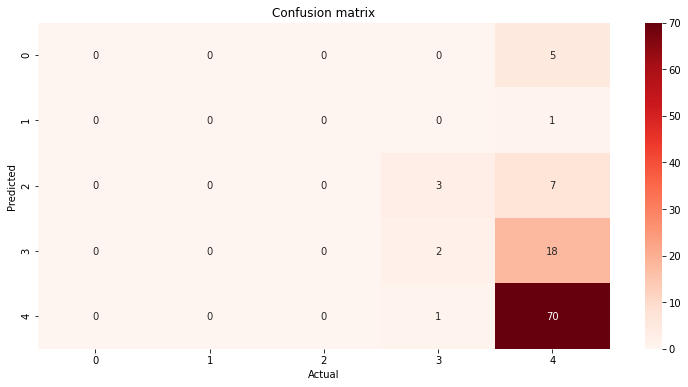

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cmap="Reds")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE
from sklearn.datasets import make_classification
from collections import Counter

X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_oversample))

#smotenc = SMOTENC([1],random_state = 101)
#X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)

#svmsmote = SVMSMOTE(random_state = 101)
#X_oversample_svm, y_oversample_svm = svmsmote.fit_resample(X_train, y_train)

#adasyn = ADASYN(random_state = 101)
#X_oversample_ada, y_oversample_ada = adasyn.fit_resample(y_train, y_test)



Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 900, 1: 900})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

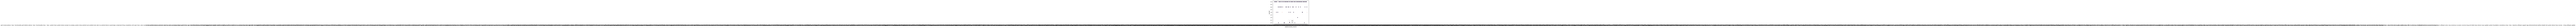

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN

df_example = ['X_test', 'y_test', 'predictions']
sns.scatterplot(x = X_test, y = y_test, hue = predictions)

smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(X_train, y_train)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test)))

classifier_o = LogisticRegression()
classifier_o.fit(X_oversample, y_oversample)
print(classification_report(y_test, classifier_o.predict(X_test)))

smotenc = SMOTENC([1],random_state = 101)
X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test)))

classifier_border = LogisticRegression()
classifier_border.fit(X_oversample_borderline, y_oversample_borderline)
print(classification_report(y_test, classifier_border.predict(X_test)))

svmsmote = SVMSMOTE(random_state = 101)
X_oversample_svm, y_oversample_svm = svmsmote.fit_resample(X_train, y_train)
classifier_svm = LogisticRegression()
classifier_svm.fit(X_oversample_svm, y_oversample_svm)
print(classification_report(y_test, classifier_svm.predict(X_test)))

adasyn = ADASYN(random_state = 101)
X_oversample_ada, y_oversample_ada = adasyn.fit_resample(X_train, y_train)
classifier_ada = LogisticRegression()
classifier_ada.fit(X_oversample_ada, y_oversample_ada)
print(classification_report(y_test, classifier_ada.predict(X_test)))